#  Neural Network for Customer Churn Prediction


In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_auc_score ,roc_curve ,confusion_matrix
from sklearn.model_selection import cross_val_score
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout


/Users/hasit/Desktop/ME/KAGGLE/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Load and preprocess data


In [2]:
df = pd.read_csv('../bank-customer-churn-prediction-challenge/train.csv')
df.drop([ 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)

# Visualize outliers using boxplots

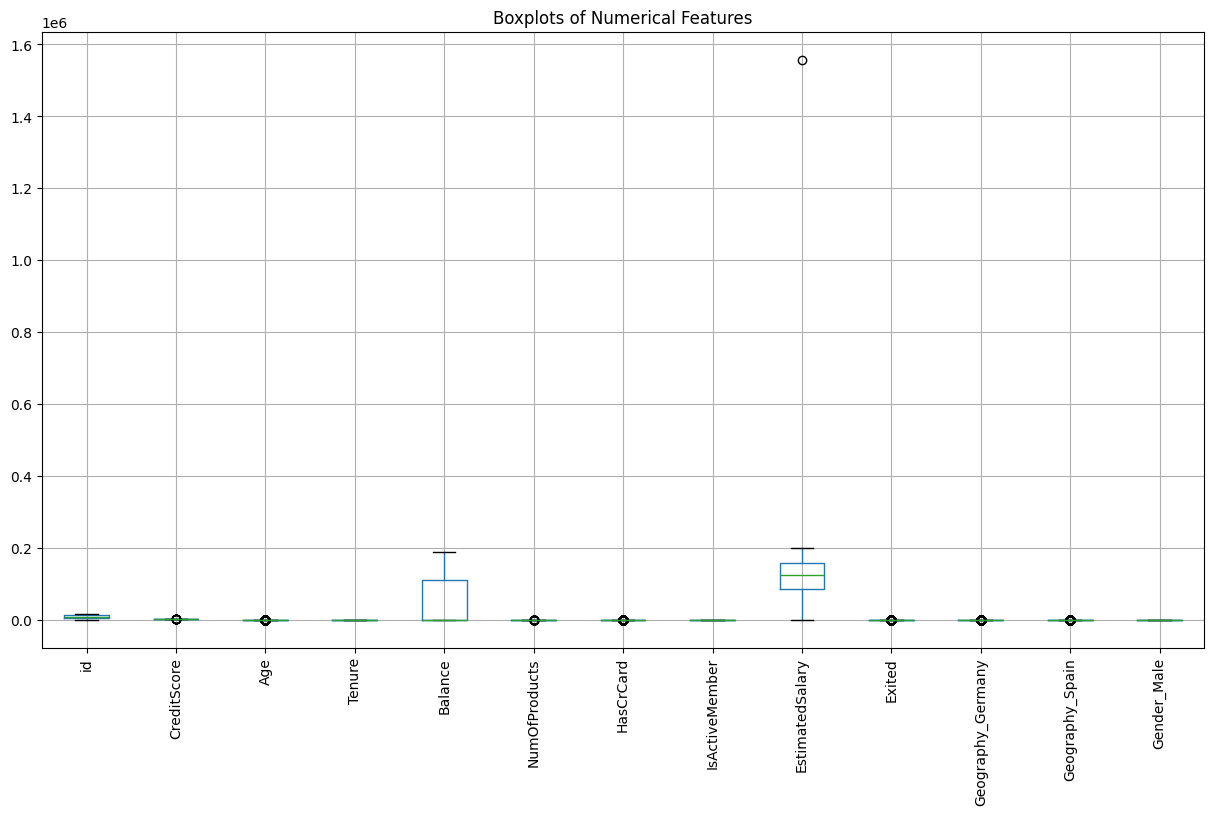

In [3]:
plt.figure(figsize=(15, 8))
df.boxplot(rot=90)
plt.title("Boxplots of Numerical Features")
plt.show()

# Split features and target


In [4]:
X = df.drop('Exited', axis=1)
y = df['Exited']

# Add target column temporarily


In [5]:
df_corr = df.copy()
df_corr["Exited"] = y

# Heatmap of correlations


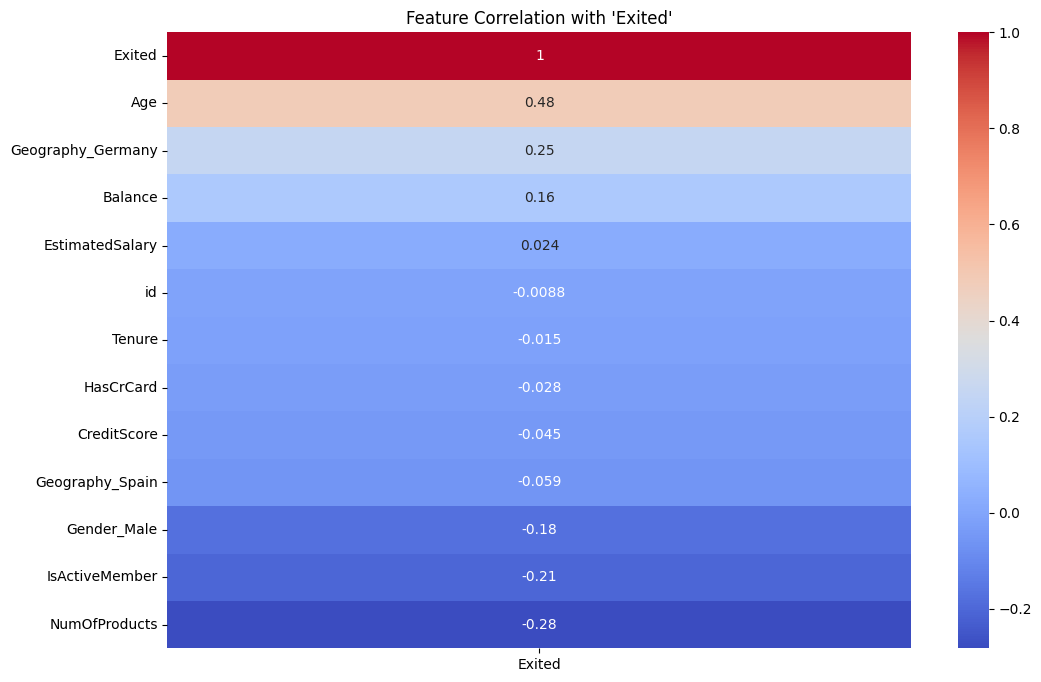

In [6]:
corr_matrix = df_corr.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix[['Exited']].sort_values('Exited', ascending=False), annot=True, cmap='coolwarm')
plt.title("Feature Correlation with 'Exited'")
plt.show()

# Distribution of target variable


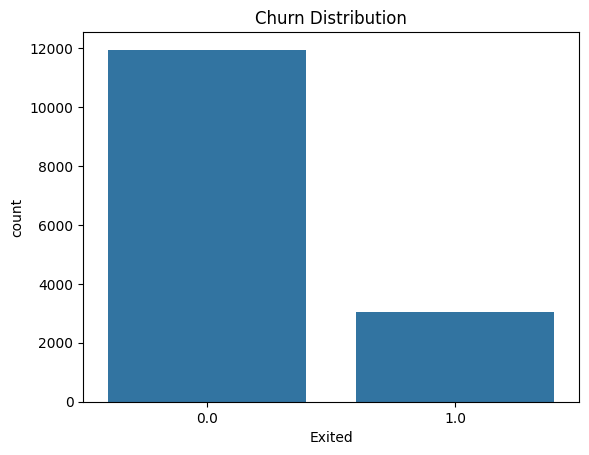

In [7]:
sns.countplot(x='Exited', data=df)
plt.title('Churn Distribution')
plt.show()

# Age distribution by churn


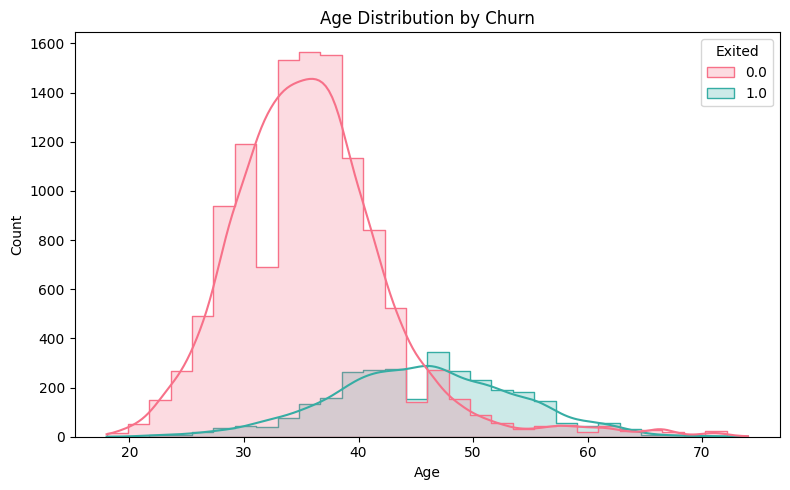

In [8]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='Age', hue='Exited', kde=True, bins=30, palette="husl", element="step")
plt.title("Age Distribution by Churn")
plt.xlabel("Age")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Prepare training set


In [9]:
corr_target = df.corr(numeric_only=True)['Exited'].abs()
selected_features = corr_target[corr_target > 0.05].index.tolist()
selected_features.remove('Exited') 
X_filtered = df[selected_features]

# Handle missing values


In [10]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_filtered)

# Scale features


In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Train-test split


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# Check Missing values

In [13]:
print("Missing values in X_train:", np.isnan(X_train).sum())
print("Missing values in X_test:", np.isnan(X_test).sum())

Missing values in X_train: 0
Missing values in X_test: 0


In [14]:
def preprocess(df):
    df = df.copy()
    for col in ['id', 'CustomerId', 'Surname']:
        if col in df.columns:
            df.drop(col, axis=1, inplace=True)
    df = pd.get_dummies(df, columns=['Geography', 'Gender'], drop_first=True)
    return df

# Build neural network model


In [15]:
model = Sequential([
        Input(shape=(X_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


# Train model


In [16]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)
joblib.dump(model, '../models/model_neural_network.pkl')
joblib.dump(imputer, "../imputer/imputer.pkl")
joblib.dump(scaler, "../scaler/scaler.pkl")
joblib.dump(X_filtered.columns, "../feature_columns/feature_columns.pkl")

print(" Logistic model and preprocessors saved.")
print("Model saved as model_neural_network.pkl")


Epoch 1/20


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7614 - loss: 0.4779 - val_accuracy: 0.8833 - val_loss: 0.2897
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8653 - loss: 0.3334 - val_accuracy: 0.8897 - val_loss: 0.2700
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8769 - loss: 0.3080 - val_accuracy: 0.8967 - val_loss: 0.2564
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8866 - loss: 0.2814 - val_accuracy: 0.9010 - val_loss: 0.2465
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8903 - loss: 0.2747 - val_accuracy: 0.9037 - val_loss: 0.2433
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8846 - loss: 0.2827 - val_accuracy: 0.8980 - val_loss: 0.2392
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8804 - loss: 0.2878 - val_accuracy: 0.9010 - val_loss: 0.2381
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8918 - loss: 0.2698 - val_accuracy: 0.9057 - val_

# Evaluate model


In [17]:
y_pred_proba = model.predict(X_test).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {acc:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')
print(classification_report(y_test, y_pred))

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.9050
F1 Score: 0.7252
ROC AUC: 0.9374
              precision    recall  f1-score   support

         0.0       0.92      0.97      0.94      2413
         1.0       0.84      0.64      0.73       587

    accuracy                           0.91      3000
   macro avg       0.88      0.80      0.83      3000
weighted avg       0.90      0.91      0.90      3000



# Confusion matrix


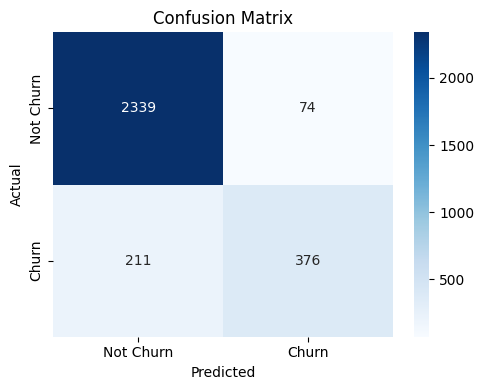

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Accuracy


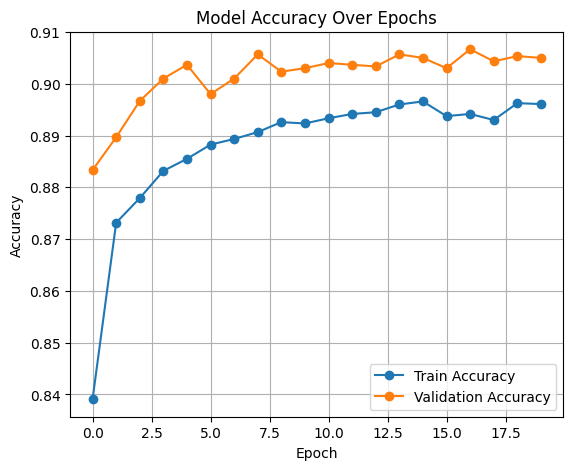

In [19]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss


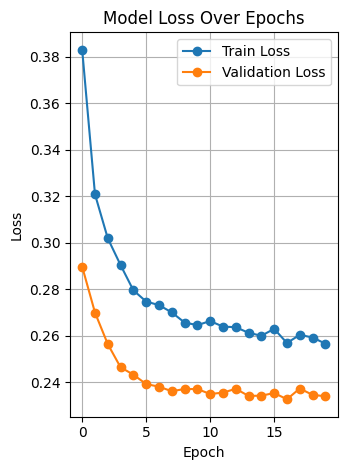

In [20]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ROC Curve

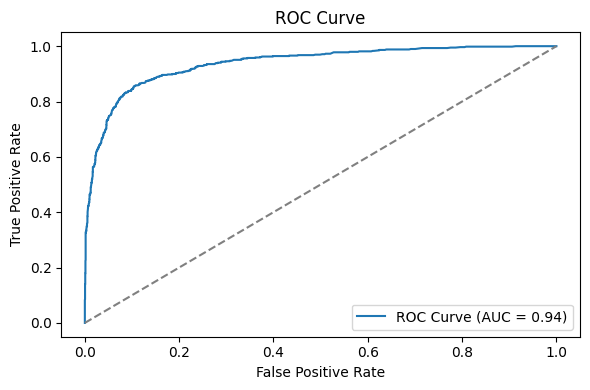

In [21]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Load Test Data

In [22]:
test_df = pd.read_csv("../bank-customer-churn-prediction-challenge/test.csv")


# Preprocess


In [23]:
X_test_raw = preprocess(test_df)


# Align columns with training set


In [24]:
feature_columns = joblib.load("../feature_columns/feature_columns.pkl")
X_test_raw = X_test_raw.reindex(columns=feature_columns, fill_value=0)

# Apply imputer and scaler


In [25]:
imputer = joblib.load("../imputer/imputer.pkl")
scaler = joblib.load("../scaler/scaler.pkl")
X_test_imputed = imputer.transform(X_test_raw)
X_test_scaled = scaler.transform(X_test_imputed)

# Load model and predict probabilities


In [26]:
model = joblib.load("../models/model_neural_network.pkl")
probas = model.predict(X_test_scaled).flatten()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# Build submission


In [27]:
submission = pd.DataFrame({
    'id': test_df['id'] if 'id' in test_df.columns else test_df['CustomerId'],
    'Exited': probas
})
submission.to_csv("../submissions/submission_nn.csv", index=False)

# Write Scores to CSV

In [28]:
score_df = pd.DataFrame({
    "Metric": ["Accuracy", "F1 Score", "ROC AUC"],
    "Score": [acc, f1, roc_auc]
})
score_df.to_csv("../scores/model_scores_nn.csv", index=False)